In [1]:
###
#  RUN ONLY ONCE TO BE IN MAIN DIRECTORY 
###

import os

# Get the current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

target_dir = os.path.dirname(current_dir)
os.chdir(target_dir)

new_dir = os.getcwd()
print("New directory:", new_dir)


Current directory: /home/chris/documents/thesis/FINALS/MARL_optimal_maintenance_graph_railway_network/epymarl
New directory: /home/chris/documents/thesis/FINALS/MARL_optimal_maintenance_graph_railway_network


In [2]:
# from epymarl.src.envs.MARL_env import MARL_env
from epymarl.src.envs.MARL_env_fake_cov import MARL_env_fake_cov as MARL_env
# from epymarl.src.envs.MARL_env_fake_cov_small import MARL_env_fake_cov_small as MARL_env
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/chris/anaconda3/envs/MARL_on_graph/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
key = "test"
graph_file_json = "./storage_graph/TEST_adjusted/"
trace_path = "storage_inference/1223_1153___REPORT___1500s_2500t_4c___REPORT_adjusted__lonle_d1lonle_d2__.nc"
trace_mean = True
node_length = 150
n_actions=4
seed = None
max_timesteps = 30
n_obs = 2

rewards_args = {
    # Emissions
    "thresholds": [1.40,2.70],
    "cost_threshold": 750,
    "n": 2.5,

    # Action - Tamping
    "fixed_cost_tamping": 0.017,
    "variable_cost_tamping": 0.030,
    "rate_of_decay_tamping": 0.55,

    # Action - Renewal
    "fixed_cost_renewal": 1,
    "variable_cost_renewal": 3.1,
    "rate_of_decay_renewal": 0.45,
}


env = MARL_env(
    graph_file_json=graph_file_json,
    trace_path=trace_path,
    rewards_args=rewards_args,
    max_timesteps=max_timesteps,
    n_actions=n_actions,
    node_length=node_length,
    trace_mean=trace_mean,
    n_obs=n_obs,
    seed=seed,
)

emissions, i = env.reset()

save_ems = []
save_act = []
save_rew = []
save_rew_a = []
save_rew_e = []

# thresholds:
thresholds_policy = [1.1,2.4]

action_threshold = [2,2]

from tqdm.auto import tqdm
for t in tqdm(range(max_timesteps)):

    actions = np.random.choice([0,2,3],env.n_nodes_graph, p=[1.,0.,0.]) # Default policy: do action 0
    threshold_1_reached = (emissions[:,0] > thresholds_policy[0])       # If emissions 1 are above threshold, do action 2
    threshold_2_reached = (emissions[:,1] > thresholds_policy[1])       # If emissions 2 are above threshold, do action 2

    actions[threshold_1_reached] = action_threshold[0]
    actions[threshold_2_reached] = action_threshold[1]

    actions[env.renewal_2_step_before] = 1
    actions[env.renewal_1_step_before] = 0
    
    emissions, rewards, done_dict, info = env.step(actions)

    save_rew_a.append(info["dict_rewards"]["cost_actions"])
    save_rew_e.append(info["dict_rewards"]["cost_emissions"])

    save_ems.append(emissions)
    save_act.append(actions)
    save_rew.append(rewards)


  0%|          | 0/30 [00:00<?, ?it/s]/home/chris/anaconda3/envs/MARL_on_graph/lib/python3.8/site-packages/scipy/stats/_multivariate.py:4456: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  z = rng.multivariate_normal(np.zeros(dim), shape, size=size)
100%|██████████| 30/30 [00:06<00:00,  4.77it/s]


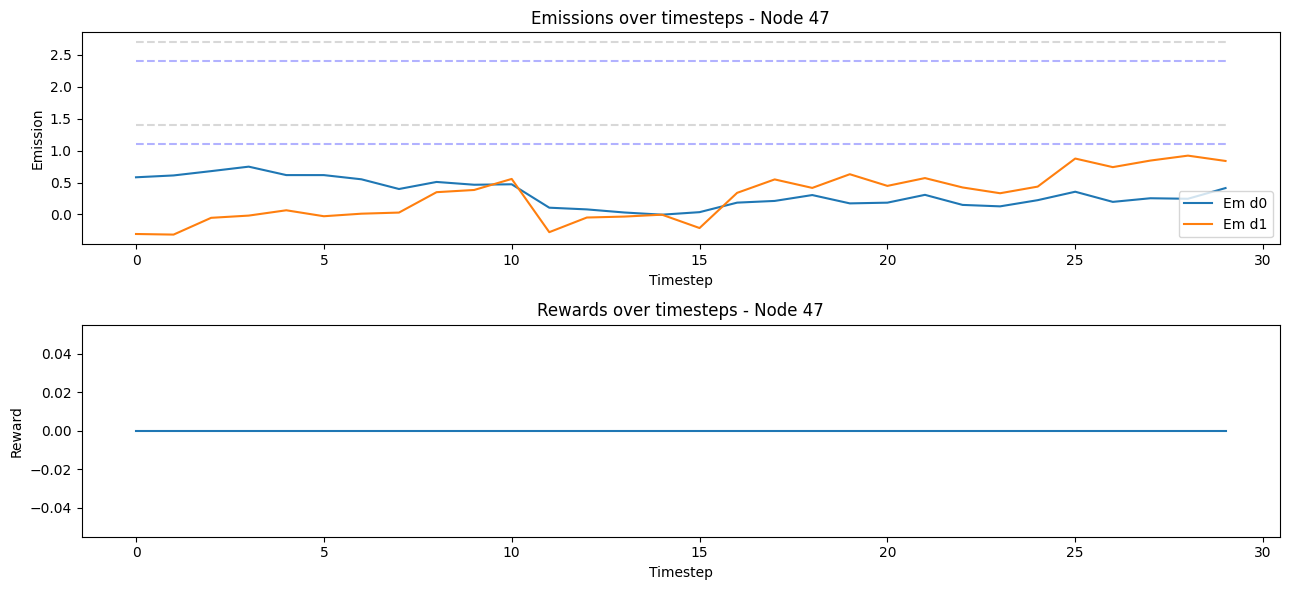

In [5]:
import matplotlib.pyplot as plt

node_plot = np.random.randint(0,env.n_nodes_graph)
node_plot = 47

all_obs_ = np.array(save_ems)[:,node_plot,:]
all_act_ = np.array(save_act)[:,node_plot]
all_rew_ = np.array(save_rew)[:,node_plot]

all_rew_cumul = np.cumsum(all_rew_, axis=0)

fig, ax = plt.subplots(2, 1, figsize=(13, 6))

min_y = np.min(all_obs_)
for t in range(len(save_ems)):
    if all_act_[t] != 0:
        ax[0].axvline(x=t, color="red", alpha=0.2)
        ax[0].text(t, min_y, f"A{all_act_[t]}", rotation=90, verticalalignment="bottom", horizontalalignment="center")
ax[0].plot(all_obs_,label=[f"Em d{i}" for i in range(2)])
ax[0].plot([env.thresholds[0]]*env.max_timesteps, color="grey", linestyle="--", alpha=0.3)
ax[0].plot([env.thresholds[1]]*env.max_timesteps, color="grey", linestyle="--", alpha=0.3)
ax[0].plot([thresholds_policy[0]]*env.max_timesteps, color="blue", linestyle="--", alpha=0.3)
ax[0].plot([thresholds_policy[1]]*env.max_timesteps, color="blue", linestyle="--", alpha=0.3)

ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Emission")
ax[0].legend()
ax[0].set_title(f"Emissions over timesteps - Node {node_plot}")


# B - Rewards over timesteps:

min_y = np.min(all_rew_cumul)
for t in range(len(all_rew_)):
    if all_act_[t] != 0:
        ax[1].axvline(x=t, color="red", alpha=0.2)
        ax[1].text(t, min_y, f"A{all_act_[t]}", rotation=90, verticalalignment="bottom", horizontalalignment="center")
ax[1].plot(all_rew_cumul)
ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("Reward")
ax[1].set_title(f"Rewards over timesteps - Node {node_plot}")

plt.tight_layout()
plt.show()

## Visualize covariance

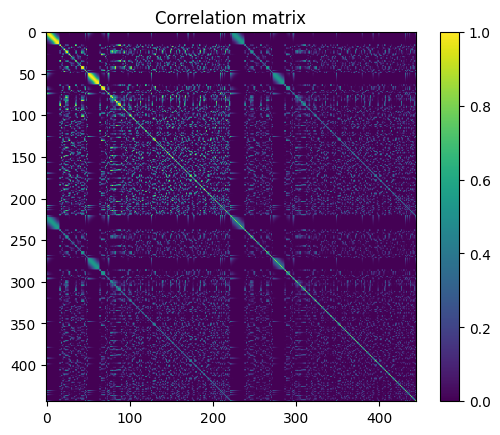

In [6]:
### Observe the covariance matrix

actions = np.zeros(env.n_nodes_graph, dtype=int)

cov_matrix = env.get_final_cov_matrix(actions)
corr_matrix = cov_matrix / np.sqrt(np.outer(np.diag(cov_matrix), np.diag(cov_matrix)))

plt.imshow(corr_matrix)
plt.colorbar()
plt.title("Correlation matrix")
plt.show()

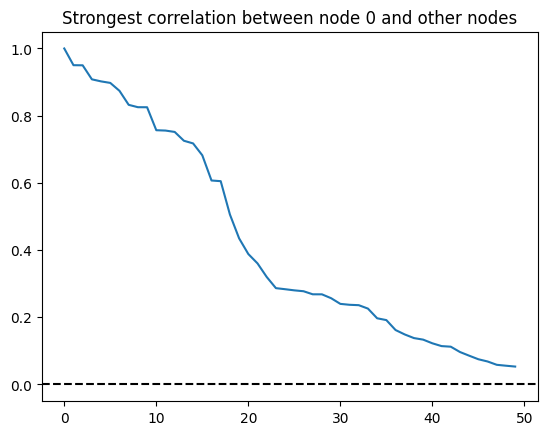

In [7]:
plt.plot(-np.sort(-corr_matrix[:env.n_nodes_graph,220])[:50])
plt.title("Strongest correlation between node 0 and other nodes")
plt.axhline(0, color="black", linestyle="--")
plt.show()

In [8]:
import networkx as nx

reference_node = 100

graph = env.graph_nx

distances = nx.single_source_shortest_path_length(graph, reference_node)

# all nodes with distance less than t
thr = 3
nodes_t = [node for node, dist in distances.items() if dist <= thr]
nodes_t = [node for node in nodes_t if node != reference_node]
distance_t = [dist for node, dist in distances.items() if dist <= thr]

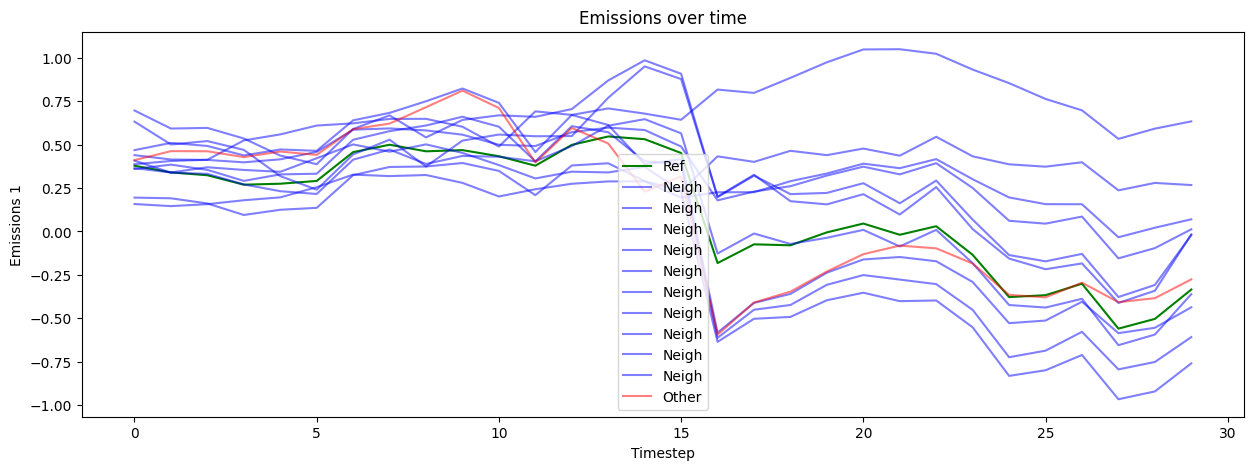

In [9]:
plt.figure(figsize=(15,5))

color_distance = np.array(distance_t) / max(distance_t)

plt.plot(np.array(save_ems)[:,reference_node,0], color="green", alpha=1, label="Ref") # node of reference
plt.plot(np.array(save_ems)[:,nodes_t,0], color="blue", alpha=0.5, label="Neigh") # its neighbors
plt.plot(np.array(save_ems)[:,43,0], color="red", alpha=0.5, label="Other") # another node, not neighbor

plt.title("Emissions over time")
plt.xlabel("Timestep")
plt.ylabel("Emissions 1")
plt.legend()

plt.show()